In [ ]:
"""
Import libraries, define a few functions, and find the necessary files.
Remember to point the model_dir variable to where the model files are!
"""

import numpy as np
import pickle as p
import mdtraj as md
import h5py as h
import torch
import os

from matplotlib import pyplot as plt
from glob import glob as g
from pprint import pprint as pp
from tqdm.notebook import tqdm
from sklearn.manifold import TSNE

if "analysis" in os.getcwd():
    os.chdir("..")
import cvae

def sglob(path):
    return sorted(g(path))

def file_name(path):
    path = path.rsplit("/",1)[-1]
    path = path.rsplit(".",1)[0]
    return path

training_file = h.File("./data/train35.h5")
training_data = training_file["cmaps"]
training_labels = training_file["labels"]

model_dir = "./models/cov35-21-08-29_1215/" # Point to model directory
model_files = sglob(model_dir+"*")
eval_data_per_epoch_files = [f for f in model_files if file_name(f).isnumeric()] # These can be viewed using the scripts in the main section
test_data_file = [f for f in model_files if file_name(f) == "test_data"][0]
test_loss_file = [f for f in model_files if file_name(f) == "test_loss"][0]
loss_stats_file = [f for f in model_files if "loss_stats" in f][0]
model_file = [ f for f in model_files if "pickle" in f][0]

In [ ]:
with open(model_file,"rb") as f:
    nn = p.load(f)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
nn = nn.to(device)
pp(nn)

def strip(traj):                                                                                                                                                                      
    for res in traj.top.residues:                                                                                                                                                         
        if res.name == "ALA":                                                                                                                                                             
            zero_idx = res.index                                                                                                                                                                                                                                                                                                                       
            break                                                                                                                                                                         
    res_range = range(zero_idx,zero_idx+595)                                                                                                                                              
    atoms = []                                                                                                                                                                            
    for i in res_range:                                                                                                                                                                   
        for atom in traj.top._residues[i].atoms:                                                                                                                                          
            atoms.append(atom.index)                                                                                                                                                      
    return traj.atom_slice(atoms)

def get_res_names(traj):
    def res_name(res):
        return f"{res.name}-{res.resSeq}"
    return [res_name(r) for r in traj.top.residues]

def pool_arr(arr,pool_size=17,cutoff=0.0,preapply=0.8):             
    shape = arr.shape
    if preapply:
        arr = arr < preapply
    try:                    
        assert shape[0] == shape[1]          
        shape = shape[0]                  
    except AssertionError:
        print("Only works for square arrays")
        raise NotImplementedError
    if shape % pool_size != 0:
        print("Please change pool_size\n"
              "None Integer division error")
        raise ArithmeticError
    iters = int(shape/pool_size)
    pooled = np.empty((iters,iters))
    for i in range(iters):
        ilow = i*pool_size
        ihgh = (i+1)*pool_size
        for j in range(iters):
            jlow = j*pool_size
            jhgh = (j+1)*pool_size
            cur_arr = arr[ilow:ihgh,jlow:jhgh]
            pooled[i,j] = 1 if np.average(cur_arr) > cutoff else 0
    return pooled

pdb_ref = "./analysis/ref.pdb"
ref = strip(md.load(pdb_ref))
res_names = get_res_names(ref)
res_names[1] = res_names[1].replace("CY1","CYS")
ref.n_residues

In [ ]:
with open(test_data_file,"rb") as f:
    test_data,test_data_labels = p.load(f)
with open(test_loss_file,"r") as f:
    test_loss = [line.strip() for line in f.readlines()]
with open(loss_stats_file,"r") as f:
    loss_stats = [line.strip() for line in f.readlines()]

In [65]:
embeddings = []
latent_size = None
print("embedding...")
for x in tqdm(test_data):
    with torch.no_grad():
        x = x.detach().view(1,1,35,35).float().to(device)
        x = np.array(nn(x)[-1].cpu())
        if latent_size is None:
            latent_size = x.shape[-1]
        embeddings.append(x)
embeddings = np.array(embeddings).reshape(-1,latent_size)
pp(embeddings.shape)

embedding...


100%|██████████| 7000/7000 [01:17<00:00, 90.68it/s] 

(7000, 3)


In [67]:
"""
T-SNE - Play with these parameters to find clusters, and try to colour by different parameters
"""
tsne_test = TSNE(perplexity=30, early_exaggeration=12.0, learning_rate=200.0, n_iter=5000,verbose=1)
transformed_test_data = tsne_test.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 7000 samples in 0.008s...
[t-SNE] Computed neighbors for 7000 samples in 0.214s...
[t-SNE] Computed conditional probabilities for sample 1000 / 7000
[t-SNE] Computed conditional probabilities for sample 2000 / 7000
[t-SNE] Computed conditional probabilities for sample 3000 / 7000
[t-SNE] Computed conditional probabilities for sample 4000 / 7000
[t-SNE] Computed conditional probabilities for sample 5000 / 7000
[t-SNE] Computed conditional probabilities for sample 6000 / 7000
[t-SNE] Computed conditional probabilities for sample 7000 / 7000
[t-SNE] Mean sigma: 0.203907
[t-SNE] KL divergence after 250 iterations with early exaggeration: 81.510628
[t-SNE] KL divergence after 5000 iterations: 1.368006


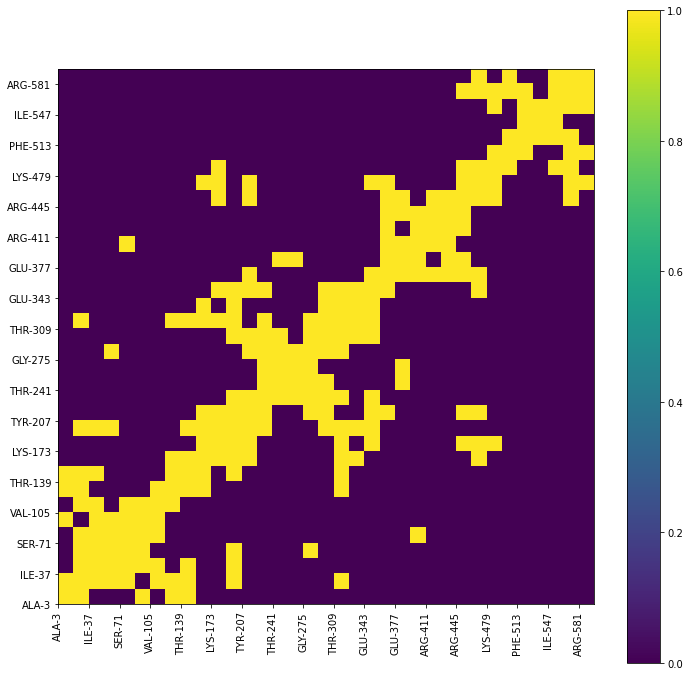

In [71]:
""" Example for CMAP plots"""
cmap = training_data[0]
plt.figure(figsize=(12,12))
plt.imshow( np.flip(cmap,axis=1))
plt.colorbar()
xt = plt.xticks([i-0.5 for i in range(35)][::2],res_names[::17][::2],rotation=90)
yt = plt.yticks([(34.5-i) for i in range(35)][::2],(res_names[::17][::2]))